<a href="https://colab.research.google.com/github/Nick7900/GLHMM_statistical_test_demo/blob/main/across_trials_and_sessions_testing_delta_theta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Across-Trials within Session testing

In this tutorial, we are going to look at how to implement the across sessions testing using the [glhmm toolbox](https://github.com/vidaurre/glhmm).
The across-session test is used to study the variability between different sessions and is ideal for understanding if any differences is happening in a longitudinal studies.

In this example dataset, a single participant engages in a memory task while undergoing Magnetoencephalography (MEG) scanning across 15 distinct sessions. Each session consists of multiple trials of the task, where they have to remember if they saw an animate or inanimate object. So it is essentially a binary task in which we will test whether there is a difference in how the subject perceives animated versus inanimate objects.

We'll focus on the occipital channels of the MEG data and perform the analysis for the four frequency bands:

  - **Delta Theta**: 1-8 Hz
  - **Alpha**: 8-13 Hz
  - **Beta**: 13-30 Hz
  - **Gamma**: 30-40 Hz.

The steps that will be implemented before that statistical testing: include loading the data, preprocessing, filtering by frequency bands, performing PCA, and training an HMM using the [glhmm toolbox](https://github.com/vidaurre/glhmm).

## Table of Contents
* [Initial setup and data preparation](#setup)
    * [Load and prepare data](#load_data)
* [(OPTIONAL) Setup GLHMM ](#setup_glhmm)
    * [(OPTIONAL) Initialize and train a HMM](#init_HMM)
* [Epoch HMM measurements](#epoch_data)
* [1.Across-trials test](#across_trials)
    * [Multivariate test](#across_trials_multi)
    * [Multiple Comparison (Multivariate test)](#multivariate_com)
    * [Visualisation (Multivariate test)](#across_trials_vis)
    * [Univariate test](#across_trials_uni)
    * [Multiple Comparison (Univariate test)](#univariate_com)
    * [Visualisation (Univariate test)](#across_trials_vis_uni)
* [2.Across-sessions-within-subject](#across_sessions)
    * [Multivariate test](#across_sessions_multi)
    * [Multiple Comparison (Multivariate test)](#multivariate_sessions_com)
    * [Visualisation (Multivariate test)](#across_sessions_vis)
    * [Univariate test](#across_sessions_uni)
    * [Multiple Comparison (Univariate test)](#univariate_sessions_com)
    * [Visualisation (Univariate test)](#across_sessions_vis_uni)
<a id="vis"></a>

## Initial setup and data preparation <a id="setup"></a>
Since we are using Google Colab for this workshop we first need to download the GLHMM toolbox

In [1]:
!pip install -q git+https://github.com/vidaurre/glhmm

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.1 MB/s eta 0:00:00


Now, we can import the required libraries and modules.


In [2]:
# Import libraries
import os
import numpy as np
import sys
import pickle
from glhmm import glhmm, graphics, statistics, io, preproc, utils
from pathlib import Path

### Load and prepare data <a id="load_data"></a>
The data for this notebook is all in the folder ```Occipital_data```.

The MEG has been for every session have been preprocessed beforehand. Specifically, we applied
* Independent Component Analysis (ICA) to remove noise components
* Removed bad channels
* Standardized the MEG data to keep a consistent scaling across measurements.
* Applied band-pass filtering to isolate the specific frequency band of interest (e.g., ```delta_theta```, ```alpha```, ```beta```, ```gamma```). This step ensures that the data used for training each HMM is focused on relevant neural oscillations.
* The Hilbert transform is used to extract the amplitude and phase information across the filtered frequency bands.

* PCA has been applied in the end to account for 90% of the variance to reduce the dimensionality of the data.
* The data has been downsampled from 1000 Hz to 100 Hz


In [5]:
# First we will download the data for this particular test
!gdown --folder 'https://drive.google.com/drive/folders/1TgH-zd3CXbRp1tGtQw426txsd4Ozohw5?usp=sharing'

Retrieving folder contents
Retrieving folder 1X7MJvHgNYCMugHjPEPAdJBdNBKE2BHFf Occipital_data
Processing file 1VMd5eJxl3aBAeub6L7NWsOCLyuU2Ujfu data_delta_theta.npy
Processing file 16N1ojOo-XiUa9feGIeua_8cYQgdkIckf event_data.pkl
Processing file 1y_nJlRBNriEbxtUCl5LStiygf11F4pJ4 Gamma_delta_theta.npy
Processing file 160KESMftMOYBbaMWoH6Jgmifh6LzTq4n hmm_delta_theta
Processing file 1LPiZPERHfWVIkAIm3swJtwvwMf_Ciz4h idx_data.npy
Processing file 1vRlgEMiUEbXii3Rf-njml9QCZmioseMy R_data.pkl
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1VMd5eJxl3aBAeub6L7NWsOCLyuU2Ujfu
From (redirected): https://drive.google.com/uc?id=1VMd5eJxl3aBAeub6L7NWsOCLyuU2Ujfu&confirm=t&uuid=f18ed9bb-5abe-45b8-bf37-8432842bb294
To: /content/2.Across_trials_sessions/Occipital_data/data_delta_theta.npy
100% 304M/304M [00:01<00:00, 181MB/s]
Downloading...
From: https://drive.google.com/uc?id=16N1oj

In [6]:
# Define directory of the data
PATH_DATA =Path('/content/2.Across_trials_sessions/Occipital_data')
# List all files in the folder
files = [f for f in PATH_DATA.iterdir() if f.is_file()]
files

[PosixPath('/content/2.Across_trials_sessions/Occipital_data/data_delta_theta.npy'),
 PosixPath('/content/2.Across_trials_sessions/Occipital_data/event_data.pkl'),
 PosixPath('/content/2.Across_trials_sessions/Occipital_data/R_data.pkl'),
 PosixPath('/content/2.Across_trials_sessions/Occipital_data/hmm_delta_theta'),
 PosixPath('/content/2.Across_trials_sessions/Occipital_data/idx_data.npy'),
 PosixPath('/content/2.Across_trials_sessions/Occipital_data/Gamma_delta_theta.npy')]

Store the data
In this step, we will define a dictionary (```data_dict```) to store data for "delta_theta" frequency bands 1-8 Hz. Here, we will store two types of data:

```D_data```: The preprossed MEG data associated with the frequency band.
```idx_data```: The index data, marks the beginning and end timepoints of each session with a shape of ```[No. of sessions, 2]```.

In [8]:
# Define frequency bands
data_dict = {
    'delta_theta': {},
}
# Load data
data_dict['delta_theta']['meg_data'] = np.load(PATH_DATA/'data_delta_theta.npy')
data_dict['delta_theta']['idx_data'] = np.load(PATH_DATA/'idx_data.npy')

**Explore the data**

Let's take a closer look at the data we'll be analyzing. We will focus on the delta_theta band for this analysis.

In [9]:
print(f"Data dimension of 'meg_data' in alpha band: {data_dict['delta_theta']['meg_data'].shape}")
print(f"Length of indices of the data': {len(data_dict['delta_theta']['idx_data'])}")
print(f"Indices of the data':\n {data_dict['delta_theta']['idx_data']}")

Data dimension of 'meg_data' in alpha band: (1086465, 35)
Length of indices of the data': 15
Indices of the data':
 [[      0  153001]
 [ 153001  303402]
 [ 303402  376853]
 [ 376853  451854]
 [ 451854  488155]
 [ 488155  564456]
 [ 564456  639857]
 [ 639857  676658]
 [ 676658  750459]
 [ 750459  787260]
 [ 787260  862661]
 [ 862661  938562]
 [ 938562  975063]
 [ 975063 1049664]
 [1049664 1086465]]


**Understanding the loaded data**

In the output above, we can see the structure of the data for the **delta_theta** frequency band:

* ```meg_data``` has a shape of ```(1086465, 33)```, where ```1086465``` represents the number of time points, and ```33``` corresponds to the number of features in the dataset. It has actually been reduced from 72 channels into 33 features after applying PCA.
* ```idx_data``` represents the indices that divide the data into 15 distinct sessions. These indices specify the start and end time points of each session, beginning at time point 0 and ending at the last time point in the data ```(1086465)```. This allows us to map specific time intervals to different sessions within the dataset.

## (OPTIONAL) Setup GLHMM <a id="setup_glhmm"></a>
In this workshop, the provided data includes the ```Gamma``` values and pre-trained HMM for each frequency band. Training a model is optional for this workshop. To save time, we will skip the model training process and directly load the pre-trained ```Gamma``` values. However, the code for training the model is provided if you'd like to try it on your own after the workshop.

We have chosen to use 12 states for the model. If you want to proceed without training an HMM and use the same ```Gamma``` values used in this tutorial, you can simply load them using the following code:

In [10]:
# Load and store the gamme values into the dictionary
data_dict["delta_theta"]["Gamma"] = np.load(PATH_DATA/'Gamma_delta_theta.npy')

### (OPTIONAL) Initialize and train a HMM <a id="init_hmm"></a>
If you prefer to train your own HMM models on each frequency band, this section provides a step-by-step guide.

**Step 1: Initialize the HMM <a id="HMM-initialize"></a>**

To start, we need to initialize an instance of the ```glhmm``` class from the ```glhmm``` module. This step involves setting the hyperparameters according to our modeling preferences.

* We set ```model_beta='no'``` because we are not modeling an interaction between two sets of variables.
* We set ```K=12``` to specify the number of states, but you can adjust this value based on your analysis.
* For the covariance type, we choose ```covtype='full'```, meaning each state will be represented by a mean and a full covariance matrix.
If you'd like to modify other aspects, such as excluding the modeling of the mean, you can adjust the hyperparameters (e.g., ```model_mean='no'```).

**Step 2: Initialize the HMM <a id="HMM-initialize"></a>**

Once the model is initialized, you can proceed to train it using the preprocessed data. In this case:

* ```X=None``` because we are not modeling interactions between two sets of time series.
* ```Y``` is the time series data (```data_con```), which is the data we want to use for state estimation.
* indices (```idx_data```) specify the start and end points of each session.

Here’s the code for training the HMM for each frequency band and store the gamma values into the dictionary ```data_dict```:

```python
K = 12 # number of states
# Filter the data
for band in data_dict.keys():
    print(f' Processing {band}')
    # Step 1: Initialize and train HMM
    hmm = glhmm.glhmm(model_beta='no', K=K, covtype='full')
    # Step 2: Train the HMM model
    Gamma, _, _ = hmm.train(X=None, Y=data_dict[band]["meg_data"], indices=data_dict[band]["idx_data"])
    data_dict[band]["Gamma"] = Gamma


**Explore data**

Let's take a closer look at the data we'll be analyzing.

In [11]:
print(f"Data dimension of 'meg_data': {data_dict['delta_theta']['meg_data'].shape}")
print(f"Data dimension of 'Gamma' in alpha band: {data_dict['delta_theta']['Gamma'].shape}")

Data dimension of 'meg_data': (1086465, 35)
Data dimension of 'Gamma' in alpha band: (1086465, 12)


The preprocessed MEG data inputted into the HMM model has transformed from a shape of (1086465, 33) [no. of timepoints, no. of features] to a shape of (1086465, 12) [no. of timepoints, no. of states]

## Epoch HMM measurements <a id="epoch_data"></a>

After training the continuous data with the Hidden Markov Model (HMM), the next step is to create epochs based on stimulus presentation times. Each session has an event code and is store in the file named ````event_data.pkl````, which marks the timepoint of when the stimulus was presented for each trial. Correspondingly, we have a file named ````R_data.pkl```` that marks whether an inanimate or animated object was presented at that corresponding timepoint, marking it as 0 or 1. ```R_data``` will serve as our behavioral variable for the statistical analysis.

In [12]:
# Load data for events
with open(PATH_DATA/'event_data.pkl', 'rb') as f:
    event_data =pickle.load(f)
# Load data for when an inanimate or animated object was presented
with open(PATH_DATA/'R_data.pkl', 'rb') as f:
    R_data = pickle.load(f)

To analyze the data, we need to downsample the time index from 1000 Hz to 100 Hz based on the presentation of events.
We will focus on a signal duration of 1 second and utilize the ````extract_epochs_from_events```` function to create epochs for our dataset.


In [13]:
# Define the original and target sampling frequencies
fs = 1000  # Original frequency in Hz
fs_target = 100  # Downsampled frequency in Hz

# Extract epochs for each frequency "delta_theta" and update the data dictionary
data_dict["delta_theta"]["gamma_epoch"], data_dict["delta_theta"]["idx_data_epoch"], data_dict["delta_theta"]["R_data_epoch"] = statistics.extract_epochs_from_events(
    data_dict["delta_theta"]["Gamma"],
    data_dict["delta_theta"]["idx_data"],
    R_data,
    event_data,
    fs=fs,
    fs_target=fs_target
)

Now, we will look at how the epoch data looks like for the delta_theta, though the shape remains consistent across bands. For our statistical test, we will use the epoched data from each trial as the input matrix, ```D_data```. This data is stored in the gamma_epochs variable within the ```data_dict``` dictionary, and its shape is``` [No. of timepoints, No. of trials, No. of states]```.

The target matrix, ```R_data```, is contained in the ```R_data_con``` variable, with a shape of ```[No. of trials]```. Each entry in this array indicates whether an inanimate (0) or animated (1) object was presented during a given trial. Lastly, we have the ```idx_data_epoch``` data, which indicates the trial associations with specific sessions



In [14]:
print(f"Shape of D_data: {data_dict['delta_theta']['gamma_epoch'].shape}")
print(f"Shape of R_data: {data_dict['delta_theta']['R_data_epoch'].shape}")
print(f"Indices for each session:\n {data_dict['delta_theta']['idx_data_epoch']}")

Shape of D_data: (100, 8407, 12)
Shape of R_data: (8407,)
Indices for each session:
 [[   0 1168]
 [1168 2323]
 [2323 2896]
 [2896 3477]
 [3477 3762]
 [3762 4343]
 [4343 4928]
 [4928 5220]
 [5220 5790]
 [5790 6079]
 [6079 6663]
 [6663 7244]
 [7244 7536]
 [7536 8114]
 [8114 8407]]


## 1.Across-trials test <a id="across_trials"></a>

As we move to the next phase of this tutorial, we'll explore how to use the ```across_trials_within_subject``` function. This function is designed to identify relationships between matrix D, representing HMM states, and certain behavioral variables or individual traits (R). In our example, it helps determine if a subject perceives animated versus inanimate objects differently within a session over time using permutation testing for the different frequency bands.

This test is particularly valuable for assessing whether a subject's perception changes over time. If no significant differences are found at any time point, it suggests that the subject perceives animated and inanimate objects similarly during those time points within a session. However, if significant differences are observed, it indicates that the subject perceives the stimuli differently, suggesting that the brain recognizes these objects in distinct ways.


In [15]:
# Set the parameters for across sessions within subject testing
method = "multivariate"
Nperm = 1000 # Number of permutations (default = 0)
test_statistic = True

Before running the test, we can visualize the average probability for each state over time for the two conditions and their difference.

This can give us an idea of how the person is reaction to condition 1 vs condition 2

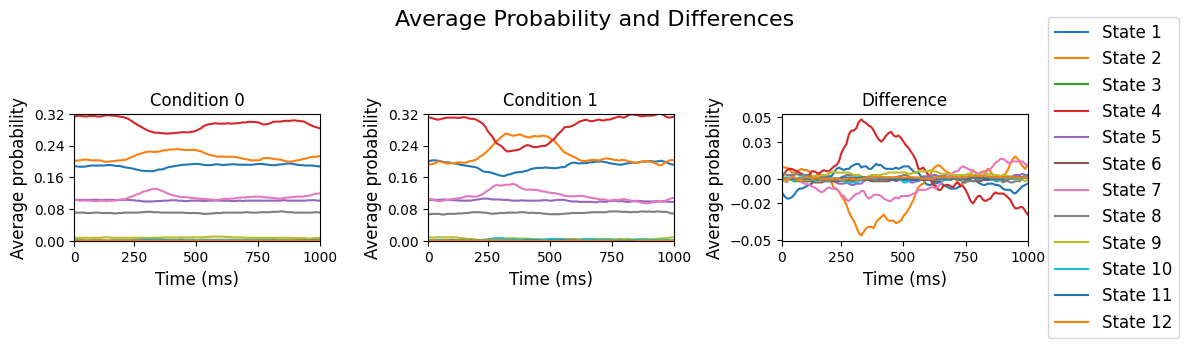

In [16]:
# Plot the average probability for each state over time for the two conditions and their difference.
graphics.plot_condition_difference(data_dict["delta_theta"]['gamma_epoch'],
                                data_dict["delta_theta"]['R_data_epoch'], figsize=(12,3),
                                title="Average Probability and Differences", xlabel="Time (ms)",
                                x_tick_min=0, x_tick_max=1000, num_x_ticks=5)

### Multivariate test <a id="across_trials_multi"></a>
In regression analysis, we are trying to explain the relationships between predictor variables (```gamma_epochs```) the response variable or signal (```R_data```).

**Understanding Multivariate:**\
The objective is to uncover the factors influencing changes in our behavioral measurements. Specifically, we examine the amount of explained variance, it can be used to analyze whether the Gamma values for every timepoint significantly contributes to explaining the observed variability in behavioral measurements in seeing an inanimate vs animated object.
A significant result indicates that there is a difference in how the patterns of ```gamma``` varies in seeing an inanimate vs animated object. A non-significant result, on the other hand, suggests that the gamma value do not not account for the variability of the behavioral measurements.

**Run the ```test_across_trials_within_session``` function**:\
To run the ```test_across_trials_within_session``` function requires providing inputs of ```gamma_epochs``` (D) of shape ``` [No. of timepoints, No. of trials, No. of states]``` and ```R_data_con``` with a shape of ```[No. of trials]```.

To initiate regression-based permutation testing, set ```method="regression"```. Additionaly, we set ```test_statistics_option="True"``` to export the permuation distribution of the statistical test



In [ ]:
# Perform across-trial testing for the delta_theta band
results_multivariate = statistics.test_across_trials_within_session(
    data_dict['delta_theta']["gamma_epoch"],
    data_dict['delta_theta']["R_data_epoch"],
    data_dict['delta_theta']["idx_data_epoch"],
    method=method,
    Nperm=Nperm,
    test_statistics_option=True
)

performing permutation testing per timepoint


100%|██████████| 100/100 [30:54<00:00, 18.55s/it]  


We can now examine the ```results_multivariate``` variable for the ```delta_theta``` band.

In [ ]:
results_multivariate

{'pval': array([0.84015984, 0.75824176, 0.77822178, 0.82917083, 0.84015984,
        0.75424575, 0.5974026 , 0.54445554, 0.38861139, 0.24675325,
        0.19280719, 0.45354645, 0.44555445, 0.17582418, 0.12787213,
        0.11888112, 0.18981019, 0.43456543, 0.44955045, 0.27872128,
        0.15784216, 0.0969031 , 0.1028971 , 0.12287712, 0.06993007,
        0.01798202, 0.00699301, 0.002997  , 0.001998  , 0.000999  ,
        0.001998  , 0.001998  , 0.000999  , 0.000999  , 0.001998  ,
        0.000999  , 0.000999  , 0.004995  , 0.00799201, 0.01098901,
        0.01098901, 0.00699301, 0.00699301, 0.002997  , 0.000999  ,
        0.003996  , 0.001998  , 0.004995  , 0.004995  , 0.004995  ,
        0.004995  , 0.03396603, 0.11188811, 0.22277722, 0.37062937,
        0.45054945, 0.54445554, 0.51648352, 0.48151848, 0.35064935,
        0.21578422, 0.17982018, 0.23376623, 0.28971029, 0.37662338,
        0.46353646, 0.51048951, 0.44555445, 0.52247752, 0.64135864,
        0.6983017 , 0.75524476, 0.707292

What we can see here is that ```result_regression``` is a dictionary containing the outcomes of a statistical analysis conducted using the specified ```method``` and ```test_type```.

Let us break it down:
* ```pval```: This array holds the p-values resulting from the permutation test. Each value corresponds to a behavioral variable and will have shape of 1 by q, see [paper](https://www.biorxiv.org/content/10.1101/2023.01.03.522583v4).

* ```base_statistics```: Stores the base statistics of the tests. In this case it is the explained variance $R^2$

* ```test_statistic```: Will by default always return a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```statistical_measures```: A dictionary that marks the units used as test_statistics

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_trials```.

* ```method```: Specifies the analytical method employed, which is ```'multivariate'```, which means that the analysis is carried out using regression-based permutation testing.

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```Nperm```: Is the number of permutations that has been performed.

### Multiple Comparison (Multivariate test) <a id="multivariate_com"></a>
Here we will apply p-value correction using cluster based correction on the multivariate test (```results_multivariate```) to take into account the risk of type 1 errors (false positive) when doing to multiple testing.

In [ ]:
alpha = 0.05 # set upper threshold
results_multivariate["pval_cluster"] =statistics.pval_cluster_based_correction(results_multivariate["test_statistics"],
                                                                                        results_multivariate["pval"], alpha=alpha)

### Visualisation (Multivariate test) <a id="across_trials_vis"></a>
When performing a multivariate test, the p-values are output as an array shaped ```[no. of timepoints, q]```, where \(q = 1\), since we only got 1 array with the conditions that indicates whether an object is animated or inanimate.

In our case, this results in an array shape of \((100, 1)\).\
To visualize the single p-value for each timepoint, use the function ```plot_p_values_over_time()```.\
To begin with, we will visualize the uncorreced p-values.

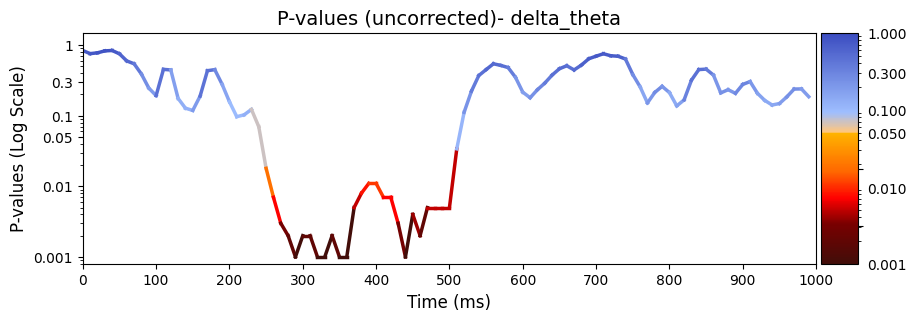

In [ ]:
# The alpha score we set for the p-values
graphics.plot_p_values_over_time(results_multivariate["pval"],
                                        title_text =f"P-values (uncorrected)- delta_theta",
                                        figsize=(10, 3), xlabel="Time (ms)",
                                        x_tick_min=0, x_tick_max=1000, num_x_ticks=11,)

**Cluster corrected**\
Plotting the cluster based corrected p-value

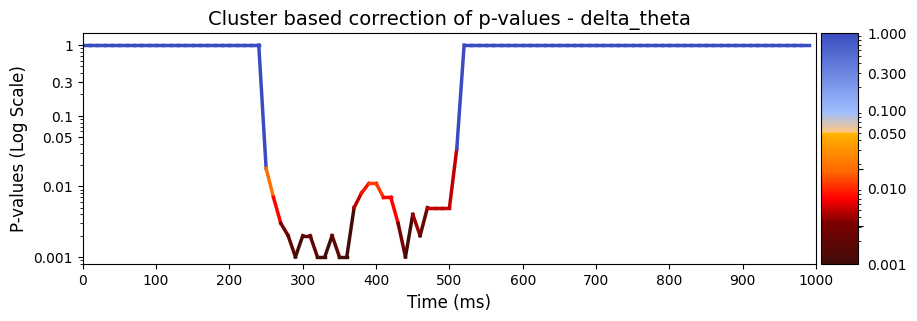

In [ ]:
# Plot p-values

graphics.plot_p_values_over_time(results_multivariate["pval_cluster"],
                                    title_text =f"Cluster based correction of p-values - delta_theta",
                                    figsize=(10, 3), xlabel="Time (ms)", x_tick_min=0, x_tick_max=1000, num_x_ticks=11)

**Visualize average probabilities and differences**\
We can now compare if the results from ```result_regression["pval"]``` correspond to the difference for each state over time for the two conditions. This will be done using the function ```plot_condition_difference```.



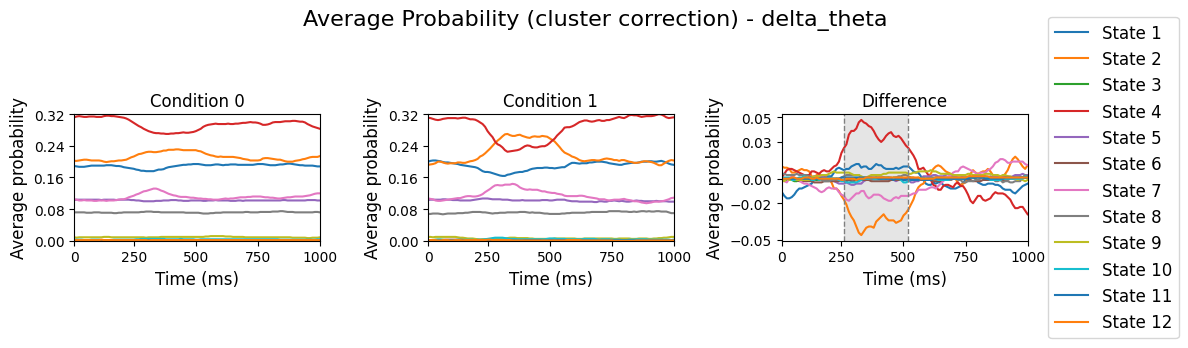

In [ ]:
# Plot p-values
band = "delta_theta"
intervals =statistics.detect_significant_intervals(results_multivariate["pval_cluster"], alpha)
# Plot the average probability for each state over time for two conditions and their difference.
graphics.plot_condition_difference(data_dict[band]["gamma_epoch"], data_dict[band]["R_data_epoch"],
                                    figsize=(12,3),vertical_lines=intervals ,
                                    highlight_boxes=True, title=f"Average Probability (cluster correction) - {band}",
                                    x_tick_min=0, x_tick_max=1000, xlabel='Time (ms)')

### Univariate test<a id="across_trials_uni"></a>
In this test, we aim to explore how different brain states relate to what the person sees. We can statistically assess the relationships between brain activity (```gamma_epoch```) and what kind of object the person is looking at (animate or inanimate). If we find a significant result, it suggests that when a specific brain state occurs, the brain's response either increases or decreases depending on whether the person is seeing a living or non-living object.

This means that the brain reacts differently when it enters that state while looking at different types of objects.


**Run the ```across_trials_within_subject``` function**:\
To run the ```across_trials_within_subject``` function we just need set the same settings as ealier besides we are chancing the method to a ```univariate``` test.

In [ ]:
# Change to a univaraite method
method = "univariate"
# Apply the statistical test
results_univariate = statistics.test_across_trials_within_session(
    data_dict["delta_theta"]["gamma_epoch"],
    data_dict["delta_theta"]["R_data_epoch"],
    data_dict["delta_theta"]["idx_data_epoch"],
    method=method,
    Nperm=Nperm,
    test_statistics_option=True
)

performing permutation testing per timepoint


100%|██████████| 100/100 [1:37:42<00:00, 58.63s/it]    


### Multiple Comparison (Univariate test) <a id="univariate_com"></a>
Applying p-value correction using cluster based correction to take into account the risk of type 1 errors (false positive) when doing to multiple testing.

In [ ]:
results_univariate["pval_cluster"] =statistics.pval_cluster_based_correction(results_univariate["test_statistics"],
                                                                            results_univariate["pval"], alpha=alpha)

### Visualisation (Univariate test)<a id="across_trials_vis_uni"></a>
When performing a univariate test, the output p-values are represented as an array with the shape [number of timepoints,𝑝,𝑞], where 𝑝=12 (representing 12 states) and 𝑞=1 (indicating a single array that differentiates between animated and inanimate objects).

In our case, this results in an array shape of (250,12).\
To visualize the matrix of p-values for each timepoint, use the function ```plot_p_value_matrix()```.\
We will start by visualizing the uncorrected p-values.

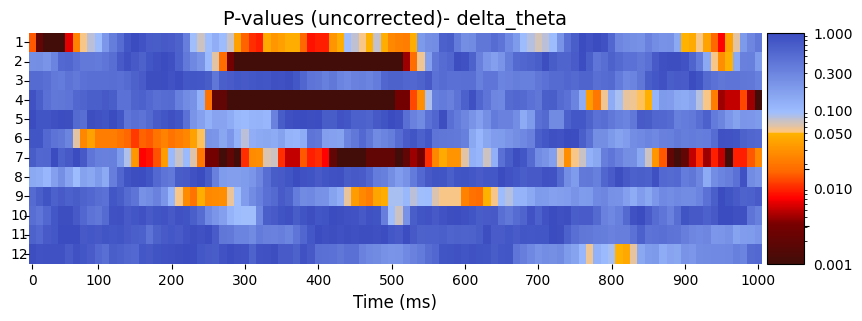

In [ ]:
# Plot p-values
graphics.plot_p_value_matrix(results_univariate["pval"].T,
                                    title_text =f"P-values (uncorrected)- {band}",
                                    figsize=(10, 3), xlabel="Time (ms)",
                                    x_tick_min=0, x_tick_max=1000, num_x_ticks=11,
                                    alpha=alpha)

**Cluster corrected**\
Plotting the cluster based corrected p-value

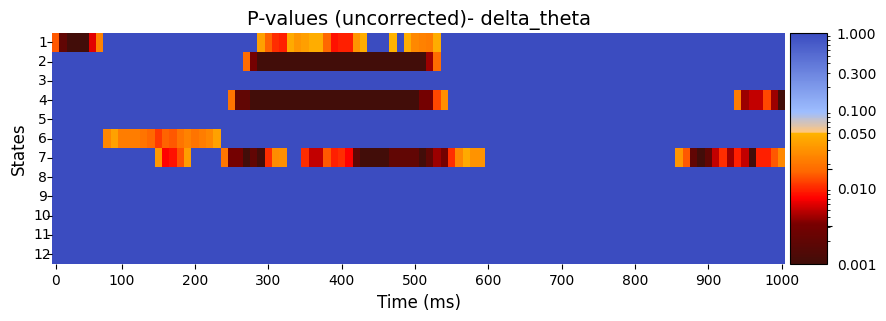

In [ ]:
# Plot -p-values
graphics.plot_p_value_matrix(results_univariate["pval_cluster"].T,
                                    title_text =f"P-values (uncorrected)- {band}",
                                    figsize=(10, 3), xlabel="Time (ms)",
                                    x_tick_min=0, x_tick_max=1000, num_x_ticks=11,
                                    alpha=alpha, ylabel="States")

**Visualization correlation coefficients (base statistics)**\
Now we can look at the correlation coefficients between the HMM states and the corresponding behavioral measurement.

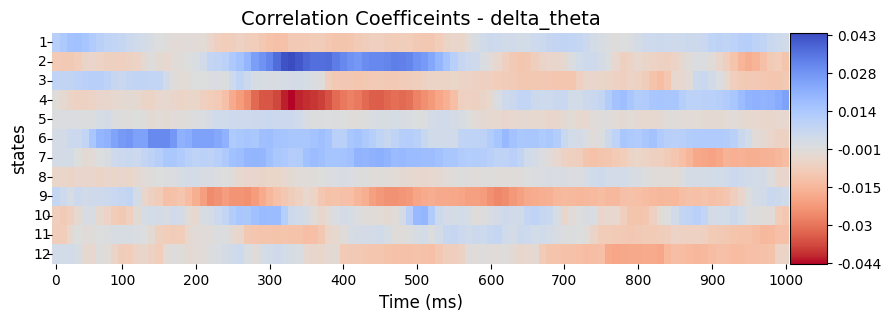

In [ ]:
graphics.plot_correlation_matrix(results_univariate["base_statistics"].T, results_univariate["statistical_measures"],
                                title_text =f"Correlation Coefficeints - {band}",
                                figsize=(10, 3), xlabel="Time (ms)", x_tick_min=0, x_tick_max=1000,
                                num_x_ticks=11, annot=False, ylabel="states")


## 2.Across-sessions-within-subject <a id="across_sessions"></a>
As we move to the next phase of this tutorial, we'll explore how to use the ```test_across_sessions_within_subject``` function. In our example, this test can be used to determine if a subject perceives animated versus inanimate objects differently over different sessions over time.

This test is particularly valuable for assessing whether a subject's perception changes over time. If no significant differences are found at any time point, it suggests the subject perceives the images consistently across sessions. However, if significant differences emerge, it indicates that the subject perceives the same image differently as time progresses.


### Multivariate test <a id="across_sessions"></a>
In this multivariate test, we are using permutation testing to examine how the brain activity (gamma_epoch) relate to what the person sees (animate or inanimate objects) across different sessions. By using $R^2$, we assess how well the variation in brain activity across multiple states can explain the differences in stimuli. This test is particularly valuable for assessing whether a subject's perception changes over time.

If there is no difference in brain activity between sessions, it suggests that the brain’s response to the stimuli is consistent over time. However, if we detect differences using $R^2$, this could indicate that the subject's perception of the task changes over time, as reflected by variations in brain activity across sessions."

**Run the ```test_across_sessions_within_subject``` function**:\
To run the ```test_across_sessions_within_subject``` function requires providing inputs of ```gamma_epochs``` (D) of shape ``` [No. of timepoints, No. of trials, No. of states]``` and ```R_data_con``` with a shape of ```[No. of trials]```.

To initiate regression-based permutation testing, set ```method="multivariate"```. Additionaly, we set ```test_statistics_option="True"``` to export the permuation distribution of the statistical test

In [ ]:
method = "multivariate"
# Perform across-subject testing for each band
results_multivariate = statistics.test_across_sessions_within_subject(
    data_dict['delta_theta']["gamma_epoch"],
    data_dict['delta_theta']["R_data_epoch"],
    data_dict['delta_theta']["idx_data_epoch"],
    method=method,
    Nperm=1000,
    test_statistics_option=True
)

Maximum number of permutations with 15 sessions is: 1.31e+12
performing permutation testing per timepoint


100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


### Multiple Comparison (Multivariate test) <a id="multivariate_sessions_com"></a>
Here we will apply p-value correction using cluster based correction on the multivariate test (```results_multivariate```) to take into account the risk of type 1 errors (false positive) when doing to multiple testing.


In [ ]:
alpha = 0.05
results_multivariate["pval_cluster"] =statistics.pval_cluster_based_correction(results_multivariate["test_statistics"],
                                                                               results_multivariate["pval"], alpha=alpha)

### Visualisation (Multivariate test) <a id="across_sessions_vis"></a>
Now that we have performed our test, we can then visualize the corrected and uncorrected p-values.\
We will make different plots using the ```graphics.py``` module.\
First we will plot the uncorrected p-values


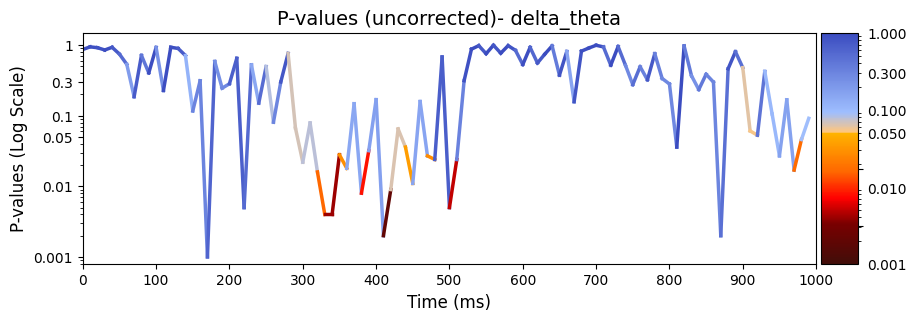

In [ ]:
# Plot p-values
graphics.plot_p_values_over_time(results_multivariate["pval"],
                                    title_text =f"P-values (uncorrected)- {band}",
                                    figsize=(10, 3), xlabel="Time (ms)",
                                    x_tick_min=0, x_tick_max=1000, num_x_ticks=11,
                                    alpha=alpha)


**Cluster corrected**\
Plotting the cluster based corrected p-value

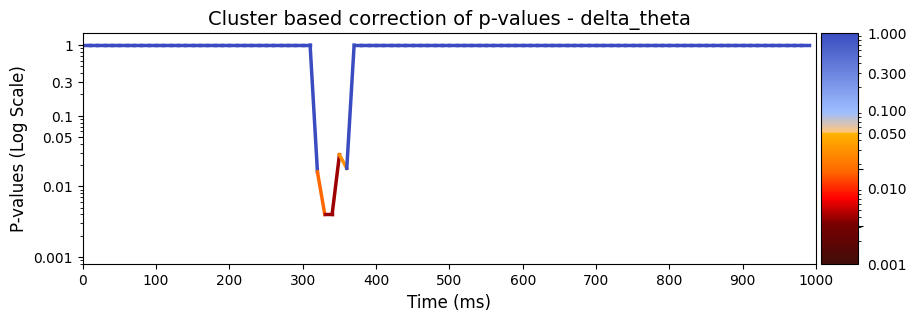

In [ ]:
# Plot p-values
graphics.plot_p_values_over_time(results_multivariate["pval_cluster"],
                                    title_text =f"Cluster based correction of p-values - {band}",
                                    figsize=(10, 3), xlabel="Time (ms)",
                                    x_tick_min=0, x_tick_max=1000, num_x_ticks=11)

### Univariate test<a id="across_sessions_uni"></a>

In this univariate test, we are using permutation testing to examine how the brain responds to the same stimuli across different sessions. Specifically, we are assessing the relationship between brain activity (gamma_epoch) and what the person sees (animate or inanimate objects) in each session. The univariate test looks at one variable at a time to detect whether different brain states consistently changes in response to the stimuli.

If there is no difference in brain activity between sessions, it suggests that the brain's response remains stable over time. However, if we find differences, this may indicate that the subject perceives the task differently in each session, showing that their brain activity changes in response to the same stimuli over time


**Run the ```test_across_sessions_within_subject``` function**:\
To run the ```test_across_sessions_within_subject``` function we just need set the same settings as ealier besides we are chancing the method to a ```univariate``` test.

In [ ]:
# Change to a univaraite method
method = "univariate"
# Perform across-subject testing for 'delta_theta' band
results_univariate = statistics.test_across_sessions_within_subject(
    data_dict['delta_theta']["gamma_epoch"],
    data_dict['delta_theta']["R_data_epoch"],
    data_dict['delta_theta']["idx_data_epoch"],
    method=method,
    Nperm=Nperm,
    test_statistics_option=True
)

Maximum number of permutations with 15 sessions is: 1.31e+12
performing permutation testing per timepoint


100%|██████████| 100/100 [16:39<00:00, 10.00s/it]


### Multiple Comparison (Univariate test) <a id="univariate_sessions_com"></a>
Applying p-value correction using cluster based correction to take into account the risk of type 1 errors (false positive) when doing to multiple testing.

In [ ]:
# perform cluster correction
results_univariate["pval_cluster"] =statistics.pval_cluster_based_correction(results_univariate["test_statistics"],
                                                                            results_univariate["pval"], alpha=alpha)

### Visualisation (Univariate test) <a id="across_sessions_vis_uni"></a>
When performing a univariate test, the output p-values are represented as an array with the shape [number of timepoints,𝑝,𝑞], where 𝑝=12 (representing 12 states) and 𝑞=1 (indicating a single array that differentiates between animated and inanimate objects).

In our case, this results in an array shape of (250,12).\
To visualize the matrix of p-values for each timepoint, use the function ```plot_p_value_matrix().```\
We will start by visualizing the uncorrected p-values.

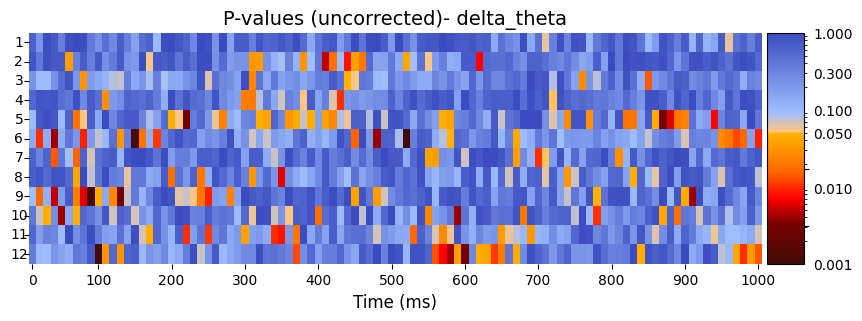

In [ ]:
# Plot p-values
graphics.plot_p_value_matrix(results_univariate["pval"].T,
                                    title_text =f"P-values (uncorrected)- {band}",
                                    figsize=(10, 3), xlabel="Time (ms)",
                                    x_tick_min=0, x_tick_max=1000, num_x_ticks=11,
                                    alpha=alpha)

**Cluster corrected**\
Plotting the cluster based corrected p-value

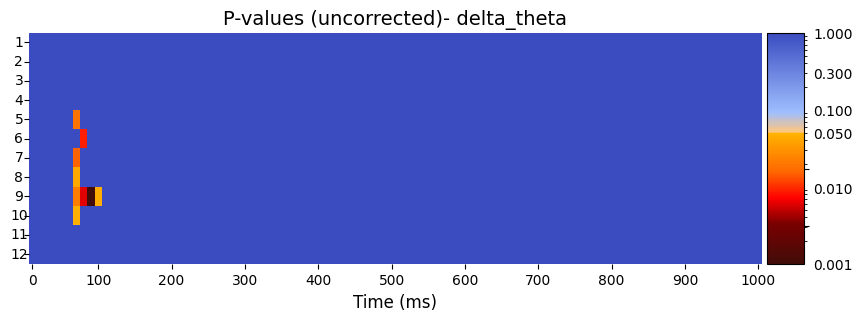

In [ ]:

# Plot p-values
graphics.plot_p_value_matrix(results_univariate["pval_cluster"].T,
                                    title_text =f"P-values (uncorrected)- {band}",
                                    figsize=(10, 3), xlabel="Time (ms)",
                                    x_tick_min=0, x_tick_max=1000, num_x_ticks=11,
                                    alpha=alpha)